# VAR modeling 
To assess the relationship between Wallstreetbest sentiment and stock's data, we will use VAR models. 

The VAR model is a statistical model for forecasting time series data. The difference between VAR and other time series models like ARIMA, ARMA or GARCH, is that VAR allows for multivariate analysis, and can also be used with exogenous variables(pretty much timeseries modeling for endogenous and common regression for exogenous).

In [ ]:
library(tidyverse);
library(recipes);
library(caret);
library(xts);
library(MTS);
library(tseries);
library(forecast);
library(vars);
library(lmtest);
library(quantmod);

Before training our model we need to deal with Null values by inputing the three missing values. Since our data is sequential, and we already have few observations, I prefered not to discard the row contsining the null values.
When fitting a VAR model we usually don't need to scale our variables so we will keep them as they are.

Some of the variables are highly correlated, for example r and logr represent the same thing, so we will keep only r for the sake of interpretability, logr might come handy in the furure to fit a GARCH model.

,r,d_vol,sent_avg,sent_var,eng_avg,eng_var,engsent_avg,engsent_var
r,1.000000000,-0.150856421,-0.074694295,-0.008354104,0.006487019,0.04417403,-0.08380139,0.010591140
d_vol,-0.150856421,1.000000000,0.002971014,-0.001899942,0.128256920,0.07772463,0.06847349,-0.003344306
sent_avg,-0.074694295,0.002971014,1.000000000,-0.727321191,0.160814468,-0.13288172,0.78081716,-0.362443206
sent_var,-0.008354104,-0.001899942,-0.727321191,1.000000000,0.039073037,0.15072593,-0.52035087,0.597085762
eng_avg,0.006487019,0.128256920,0.160814468,0.039073037,1.000000000,0.49805770,0.56379709,0.592579401
eng_var,0.044174035,0.077724634,-0.132881721,0.150725931,0.498057703,1.00000000,0.16172549,0.572485419
engsent_avg,-0.083801386,0.068473492,0.780817159,-0.520350867,0.563797089,0.16172549,1.00000000,-0.027475462
engsent_var,0.010591140,-0.003344306,-0.362443206,0.597085762,0.592579401,0.57248542,-0.02747546,1.000000000


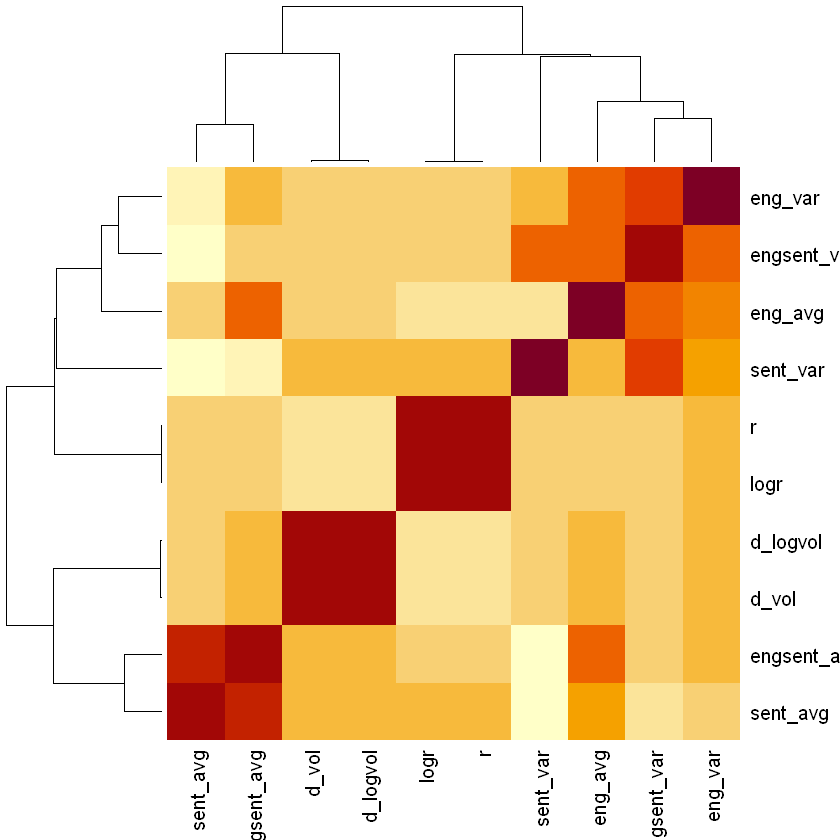

In [2]:
r50 <- read.csv(file = "../data/r50_2023.csv",
                header = TRUE,
                sep = ",",
                dec = ".")

# Center and scale
recipe <-
    recipe(~., data = r50) %>%
    step_impute_mean(all_numeric()) %>%
    step_select(-c(X, timestamp)) 

recipe <- prep(recipe, training = r50)

r50_clean <- bake(recipe, r50)

heatmap(cor(r50_clean))

r50_clean <- subset(r50_clean, select = -c(logr, d_logvol))
    
r50_clean <- r50_clean[c( "r", "d_vol", "sent_avg", "sent_var", "eng_avg", "eng_var", "engsent_avg", "engsent_var")] 

cor(r50_clean)



One of the key assumptions of VAR is the stationarity of the data, that is, that the time series have costant mean, costant variance and costant autocovariance. To make it simple, we don't want to have patterns or long term trends, but we want our time series to behave in a similar manner across different periods. 

We can assess stationarity by rejecting the null hypothesis of the Augmented Dickey-Fuller (ADF) test. In the table below we can see that all our feature are stationary, while sent_var might not be stationary. Due to the p-value we can assume that it should be stationary.

In [3]:
variables <- colnames(r50_clean)

adf_results <- data.frame(Variable = character(length(variables)), ADF_pValue = numeric(length(variables)))

# Perform the adf test to all variables
for (i in seq_along(variables)) {
    suppressWarnings(adf_result <- adf.test(r50_clean[[variables[i]]]))
    adf_results[i, "Variable"] <- variables[i]
    adf_results[i, "P_Value"] <- adf_result$p.value
}

# Print the variable names and p-values of adf test
head(adf_results[, c("Variable", "P_Value")],10)


,Variable,P_Value
,<chr>,<dbl>
1,r,0.01000000
2,d_vol,0.01000000
3,sent_avg,0.01437974
4,sent_var,0.05703999
5,eng_avg,0.02047366
6,eng_var,0.01000000
7,engsent_avg,0.01000000
8,engsent_var,0.01000000


Once we have checked that the time series respect the model assumptions we can prepare the dataset fot training and testing. We will have different datasets for VAR and VARX, this because VARX needs an additional dataset input for exogenolus variables, that will be treated like normal estimators, without taking into account their lag. In orderot explore the impact of sentiment we will analyse it both as endogenous and as exogenous variables.

In [4]:
# Train/Test split
idx <- round(nrow(r50_clean) * 0.9)

df_train <- head(r50_clean, idx) %>% na.omit()
df_test <- tail(r50_clean,
            nrow(r50_clean) - idx) %>%
            na.omit()

# Set r and d_vol as endogenous variables
endogenous <- c("r", "d_vol")

# Set sentiment variables as exogenous
exogenous <- c("sent_avg", "eng_var")

# VARX Exogenous
df_ex_train <- df_train[exogenous]
df_ex_test <- df_test[exogenous] 

# VARX Endogenous
df_end_train <- df_train[endogenous]
df_end_test <- df_test[endogenous]

Now that we have our training data, we can find the optimal number of lags to fit our model. VARoder and VARoderI both provide an insight on which is the best number of lags, with the first one using statistical tests, the latter using impulse response functions. 

VARselect and VARorderI both suggest that past observations are not meaningful predictors for future observations, and that the vriables are not interdependent. Using a lag of 0 would suggest that the model will be a simple linear regression.

We will keep this in mind but we will use the 10 lags suggested by AIC to confirm our assumption.

In [29]:
# Lag selection for VAR
VARorder(df_train, 10)
VARorderI(df_train, 10)

# Lag selection for VARX
VARselect(df_end_train, exogen = df_ex_train)

selected order: aic =  10 
selected order: bic =  0 
selected order: hq =  0 
Summary table:  
       p     AIC     BIC     HQ    M(p) p-value
 [1,]  0  3.3510  3.3510 3.3510  0.0000  0.0000
 [2,]  1  3.5090  5.0892 4.1498 90.9621  0.0150
 [3,]  2  3.8364  6.9969 5.1181 69.0192  0.3117
 [4,]  3  4.0967  8.8375 6.0193 67.1796  0.3687
 [5,]  4  4.4013 10.7223 6.9647 56.9666  0.7212
 [6,]  5  4.2879 12.1891 7.4921 74.0443  0.1831
 [7,]  6  4.2770 13.7585 8.1221 58.6669  0.6649
 [8,]  7  3.8836 14.9453 8.3696 65.0600  0.4396
 [9,]  8  2.9072 15.5492 8.0340 72.0486  0.2291
[10,]  9  1.5572 15.7793 7.3248 64.3715  0.4635
[11,] 10 -1.7292 14.0732 4.6792 78.0629  0.1112
selected order: aic =  10 
selected order: bic =  0 
selected order: hq =  0 
M statistic and its p-value 
       Mstat        pv
 [1,] 125.53 6.915e-06
 [2,]  70.17 2.786e-01
 [3,]  63.15 5.065e-01
 [4,]  49.03 9.167e-01
 [5,]  79.39 9.310e-02
 [6,]  54.94 7.831e-01
 [7,]  66.03 4.065e-01
 [8,]  72.36 2.215e-01
 [9,]  71.11 2.

,1,2,3,4,5,6,7,8,9,10
AIC(n),-1.130106e+01,-1.127729e+01,-1.122933e+01,-1.122768e+01,-1.126057e+01,-1.126118e+01,-1.127864e+01,-1.126263e+01,-1.126261e+01,-1.119967e+01
HQ(n),-1.119500e+01,-1.112880e+01,-1.103843e+01,-1.099435e+01,-1.098481e+01,-1.094301e+01,-1.091804e+01,-1.085960e+01,-1.081716e+01,-1.071179e+01
SC(n),-1.103893e+01,-1.091030e+01,-1.075749e+01,-1.065099e+01,-1.057902e+01,-1.047478e+01,-1.038739e+01,-1.026652e+01,-1.016165e+01,-9.993853e+00
FPE(n),1.236193e-05,1.266315e-05,1.329228e-05,1.332538e-05,1.290988e-05,1.292325e-05,1.272722e-05,1.296849e-05,1.301338e-05,1.391722e-05


Our first VAR model will have a ton of variables, because each of the lags of each feature will be a variable itself. So to reduce complexity we will just remove the variables whose coefficients have a p-value smaller than 0.05 and we will re-fit the model accordingly. Once we refined our model we can then check how returns are affected by sudden changes in sentiment.  

However, we need to be careful when assessing the predictive power of our variables, as having many lags can lead to false positives and high autocorrelation. As we can see from the residuals some of our variables are highly autocorrelated.

In [31]:
var_1 <- VAR(df_train, p = 10)

var_2 <- restrict(var_1,thresh = 2)
summary(var_2)

var_irf <- irf(var_2, response = "r")
plot(var_irf)


VAR Estimation Results:
Endogenous variables: r, d_vol, sent_avg, sent_var, eng_avg, eng_var, engsent_avg, engsent_var 
Deterministic variables: const 
Sample size: 99 
Log Likelihood: -1108.987 
Roots of the characteristic polynomial:
1.119 1.119 1.066 1.059 1.059 1.054 1.005 1.005 1.004 1.004 0.9955 0.9955 0.9845 0.9845 0.961 0.961 0.9595 0.9595 0.9584 0.9584 0.9545 0.9545 0.9534 0.9534 0.952 0.952 0.9515 0.9515 0.9496 0.9496 0.9449 0.9449 0.9438 0.9438 0.9425 0.9425 0.9351 0.9351 0.9263 0.9263 0.9237 0.9237 0.916 0.916 0.9123 0.9123 0.9096 0.8964 0.8964 0.8916 0.8916 0.8907 0.8905 0.8905 0.8867 0.8867 0.8847 0.8847 0.8446 0.8446 0.8398 0.8398 0.8134 0.8134 0.7935 0.7531 0.7531 0.7328 0.7328 0.7309 0.7309 0.6207 0.6207 0.272 0.2627 0.2627 2.712e-15     0     0     0
Call:
VAR(y = df_train, p = 10)


Estimation results for equation r: 
r = r.l1 + sent_var.l2 + eng_avg.l2 + engsent_avg.l2 + sent_var.l3 + eng_var.l3 + engsent_var.l3 + d_vol.l4 + sent_avg.l5 + d_vol.l7 + r.l8 + sent_avg

In [7]:
#VARX model---------------

x1 <- VAR(df_end_train, 7, exogen = df_ex_train)

x2 <- restrict(x1, method = "ser")
summary(x2)


VAR Estimation Results:
Endogenous variables: r, d_vol 
Deterministic variables: const 
Sample size: 102 
Log Likelihood: 307.852 
Roots of the characteristic polynomial:
0.8289 0.8289 0.8238 0.8238 0.8049 0.8025 0.8025 0.7651 0.7651 0.7277 0.7277 0.6611     0     0
Call:
VAR(y = df_end_train, p = 7, exogen = df_ex_train)


Estimation results for equation r: 
r = r.l5 + d_vol.l7 

          Estimate Std. Error t value Pr(>|t|)  
r.l5     -0.215740   0.094459  -2.284   0.0245 *
d_vol.l7 -0.021266   0.008211  -2.590   0.0110 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.01617 on 100 degrees of freedom
Multiple R-Squared: 0.1022,	Adjusted R-squared: 0.08425 
F-statistic: 5.692 on 2 and 100 DF,  p-value: 0.004559 


Estimation results for equation d_vol: 
d_vol = d_vol.l2 + d_vol.l4 + r.l5 

         Estimate Std. Error t value Pr(>|t|)  
d_vol.l2 -0.22925    0.09673  -2.370   0.0197 *
d_vol.l4 -0.21010    0.09647  -2.178   0.0318 *
r.l5

The final step of our research is to perform a Granger Causality test to assess whether the sentiment of WallStreetBets SubReddit really had a causal effect on returns. The granger Test basically tells us if using the lags of one variable leads to a better forcasting of another one.

The Granger Test's results clearly show that there is indeed a causal effect between sentiment and returns, but the high correlation between residuals indicates that the model is overfitted, and won't be able to accurately predict future returns of the R50 index.

In [33]:
# Perform Granger causality test between engagement and other variables
granger_test_result <- causality(var_1, cause = "engsent_avg",boot = TRUE)
print(granger_test_result)

$Granger

	Granger causality H0: r do not Granger-cause d_vol sent_avg sent_var
	eng_avg eng_var engsent_avg engsent_var

data:  VAR object var_1
F-Test = 1.5982, boot.runs = 100, p-value < 2.2e-16


$Instant

	H0: No instantaneous causality between: r and d_vol sent_avg sent_var
	eng_avg eng_var engsent_avg engsent_var

data:  VAR object var_1
Chi-squared = 35.921, df = 7, p-value = 7.501e-06


